<a href="https://colab.research.google.com/github/JoshuaHarper98/MM908-Industrial-Project/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dependencies 

In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from gensim import matutils
from collections import defaultdict
import itertools
import multiprocessing
from time import time

In [ ]:
!python -m spacy download en_vectors_web_lg

     |████████████████████████████████| 661.8 MB 1.1 MB/s 
  Created wheel for en-vectors-web-lg: filename=en_vectors_web_lg-2.1.0-py3-none-any.whl size=663461745 sha256=c2c5de8ff3102d1f5e34a3133e46a0a29746a02f2ce8856e5180674c45fb9b7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-xphnj64_/wheels/14/24/1b/61b40d65ed3ccd236ac714862d7ec3a999b99d495785563e09
Successfully built en-vectors-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_vectors_web_lg')


# Loading the data


In [ ]:
stopwords = set(STOP_WORDS)

In [ ]:
preprocessed = pd.read_pickle("/content/drive/MyDrive/Data/preprocessed_final.pkl")

In [ ]:
preprocessed.Text[0]

"Set null on Primary Named Policyholder to 'No PAYE scheme in operation'.\r\nSet null on Primary Named Policyholder to 'true'."

In [ ]:
preprocessed.clean[0]

'Set null on Primary Named Policyholder to No PAYE scheme in operation Set null on Primary Named Policyholder to true'

In [ ]:
preprocessed['length'] = [len(text) for text in preprocessed.tokens.values]

In [ ]:
preprocessed = preprocessed[preprocessed.length > 3]

In [ ]:
preprocessed.head()

,Index,POLICYID,Text,Product_Code,Claim,Number_of_Claims,emails,emails_count,urls,url_flags,clean,adjs_verbs,nouns,entities,tokens,lemmas,length
0,1,100218,Set null on Primary Named Policyholder to 'No ...,CPO,No,0,[],0,[],0,Set null on Primary Named Policyholder to No P...,"[name, name, true]","[set, null, Primary, Policyholder, PAYE, schem...","[Primary_name_Policyholder/ORG, Primary_name_P...","[set, null, primary, name, policyholder, paye,...","[set, null, on, Primary, Named, Policyholder, ...",14
1,2,100235,Set null on Primary Named Policyholder to 'No ...,CPO,No,0,[],0,[],0,Set null on Primary Named Policyholder to No P...,"[name, name, true]","[set, null, Primary, Policyholder, PAYE, schem...","[Primary_name_Policyholder/ORG, Primary_name_P...","[set, null, primary, name, policyholder, paye,...","[set, null, on, Primary, Named, Policyholder, ...",14
3,4,100423,NOW BEING DEBITTED ON GW\r\nNO CLAIMS\r\nON CO...,CPO,No,0,[],0,[],0,NOW BEING DEBITTED ON GW NO CLAIMS ON COVE SIN...,[],"[DEBITTED, GW, claims, COVE, change, APPLIED, ...",[DEBITTED/ORG],"[debitted, claims, cove, changes, applied, inc]","[now, be, debitte, ON, GW, CLAIMS, on, COVE, s...",6
4,5,100449,Set null on Primary Named Policyholder to 'No ...,CPO,No,0,[],0,[],0,Set null on Primary Named Policyholder to No P...,"[name, name, true]","[set, null, Primary, Policyholder, PAYE, schem...","[Primary_name_Policyholder/ORG, Primary_name_P...","[set, null, primary, name, policyholder, paye,...","[set, null, on, Primary, Named, Policyholder, ...",14
6,7,100457,St Maryâ€™s Close \r\nPOL Â£10m and Legal expe...,CPO,No,0,[],0,[],0,St Mary Close POL 10m and Legal expenses 100k ...,"[legal, net, close, communal, block, paved, fr...","[St, Mary, Close, POL, m, expense, location, l...","[St_Mary/PERSON, legal/ORG, Premises/LOC, IPT_...","[mary, close, pol, m, legal, expense, net, loc...","[St, Mary, Close, POL, 10, m, and, legal, expe...",36


In [ ]:
preprocessed['lemmas'] = preprocessed['lemmas'].map(lambda x: list(map(str.lower, x)))

In [ ]:
preprocessed.head()

,Index,POLICYID,Text,Product_Code,Claim,Number_of_Claims,emails,emails_count,urls,url_flags,clean,adjs_verbs,nouns,entities,tokens,lemmas,length
0,1,100218,Set null on Primary Named Policyholder to 'No ...,CPO,No,0,[],0,[],0,Set null on Primary Named Policyholder to No P...,"[name, name, true]","[set, null, Primary, Policyholder, PAYE, schem...","[Primary_name_Policyholder/ORG, Primary_name_P...","[set, null, primary, name, policyholder, paye,...","[set, null, on, primary, named, policyholder, ...",14
1,2,100235,Set null on Primary Named Policyholder to 'No ...,CPO,No,0,[],0,[],0,Set null on Primary Named Policyholder to No P...,"[name, name, true]","[set, null, Primary, Policyholder, PAYE, schem...","[Primary_name_Policyholder/ORG, Primary_name_P...","[set, null, primary, name, policyholder, paye,...","[set, null, on, primary, named, policyholder, ...",14
3,4,100423,NOW BEING DEBITTED ON GW\r\nNO CLAIMS\r\nON CO...,CPO,No,0,[],0,[],0,NOW BEING DEBITTED ON GW NO CLAIMS ON COVE SIN...,[],"[DEBITTED, GW, claims, COVE, change, APPLIED, ...",[DEBITTED/ORG],"[debitted, claims, cove, changes, applied, inc]","[now, be, debitte, on, gw, claims, on, cove, s...",6
4,5,100449,Set null on Primary Named Policyholder to 'No ...,CPO,No,0,[],0,[],0,Set null on Primary Named Policyholder to No P...,"[name, name, true]","[set, null, Primary, Policyholder, PAYE, schem...","[Primary_name_Policyholder/ORG, Primary_name_P...","[set, null, primary, name, policyholder, paye,...","[set, null, on, primary, named, policyholder, ...",14
6,7,100457,St Maryâ€™s Close \r\nPOL Â£10m and Legal expe...,CPO,No,0,[],0,[],0,St Mary Close POL 10m and Legal expenses 100k ...,"[legal, net, close, communal, block, paved, fr...","[St, Mary, Close, POL, m, expense, location, l...","[St_Mary/PERSON, legal/ORG, Premises/LOC, IPT_...","[mary, close, pol, m, legal, expense, net, loc...","[st, mary, close, pol, 10, m, and, legal, expe...",36


In [ ]:
preprocessed.Claim.value_counts()

No     120285
Yes     30367
Name: Claim, dtype: int64

Text(0.5, 1.0, 'Histogram of Claim Counts')

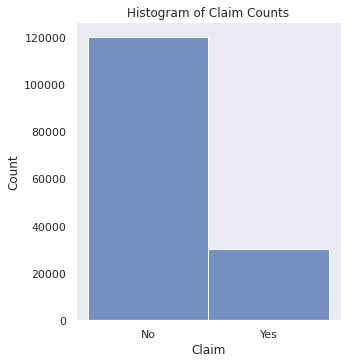

In [ ]:
sns.set_theme(style="dark")
sns.displot(preprocessed.Claim)
plt.title('Histogram of Claim Counts')

In [ ]:
preprocessed.Number_of_Claims.value_counts()

0      120285
1       17355
2        5751
3        2555
4        1315
        ...  
92          1
349         1
65          1
69          1
85          1
Name: Number_of_Claims, Length: 146, dtype: int64

In [ ]:
preprocessed.Number_of_Claims.sum()

95484

In [ ]:
len(preprocessed[preprocessed.Number_of_Claims > 1])

13012

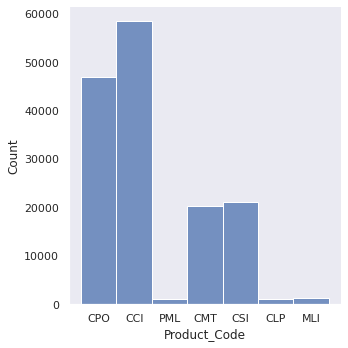

In [ ]:
sns.displot(preprocessed.Product_Code)

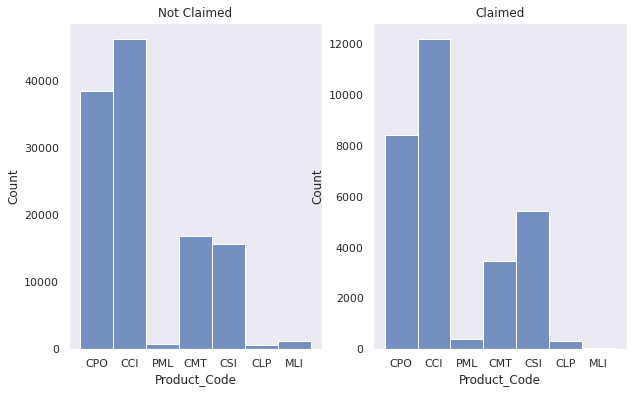

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
sns.histplot(preprocessed[preprocessed["Claim"] == 'No'].Product_Code, ax=ax[0])
sns.histplot(preprocessed[preprocessed["Claim"] == 'Yes'].Product_Code, ax=ax[1])
ax[0].set_title('Not Claimed')
ax[1].set_title('Claimed')
fig.show()

In [ ]:
data = preprocessed[['lemmas', 'Claim', 'Number_of_Claims', 'tokens', 'Product_Code', 'POLICYID']]
data = data.rename(columns = {'lemmas' : 'text'})

# Train and Test Split


In [ ]:
from sklearn.model_selection import train_test_split 

train, test = train_test_split(data, shuffle = True, stratify = data.Claim, train_size = 0.80, random_state = 50)

train.shape, test.shape

((120521, 6), (30131, 6))

In [ ]:
# Adverserial Validation
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold


def adversarial_validation(X, Y, n_splits = 10):
    
    # Combine both datasets
    sparse_merge = sparse.vstack((X, Y))
    
    # Label the datasets
    y = np.array([0 for _ in range(X.shape[0])] + [1 for _ in range(Y.shape[0])])
    
    # Do 10 Fold CV 
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)

    lr_auc = np.array([])
    rf_auc = np.array([])
    for train_idx, test_idx in kfold.split(sparse_merge, y):
    
        #Run Log Reg
        x_train, y_train = sparse_merge[train_idx], y[train_idx]
        x_test, y_test = sparse_merge[test_idx], y[test_idx]
        
        log_reg = SGDClassifier(loss = 'log')
        log_reg.fit(x_train, y_train)
        y_test_prob = log_reg.predict_proba(x_test)[:,1]
        lr_auc = np.append(lr_auc, roc_auc_score(y_test, y_test_prob))
        # Run RF
        rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
        rf.fit(x_train, y_train)
        y_test_prob = rf.predict_proba(x_test)[:,1]
        rf_auc = np.append(rf_auc, roc_auc_score(y_test, y_test_prob))

    
    # Display results
    print('Logisitic Regression AUC : {:.3f}'.format(lr_auc.mean()))
    print('Random Forest AUC : {:.3f}'.format(rf_auc.mean()))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle 

def dummy(doc):
    return doc

bow = CountVectorizer(
        tokenizer=dummy,
        preprocessor=dummy,
    )  

x_train = bow.fit_transform(train.text.values)
x_test = bow.transform(test.text.values)

x_test = shuffle(x_test)

adversarial_validation(x_train[:len(test)], x_test)

In [ ]:
print('Train Positive Class % : {:.1f}'.format((sum(train.Claim == 'Yes')/train.shape[0])*100))
print('Test Positive Class % : {:.1f}'.format((sum(test.Claim == 'Yes')/test.shape[0])*100))

print('Train Size: {}'.format(train.shape[0]))
print('Test Size: {}'.format(test.shape[0]))

In [ ]:
y_train = train['Claim']

In [ ]:
y_train

# Data Visualisaton


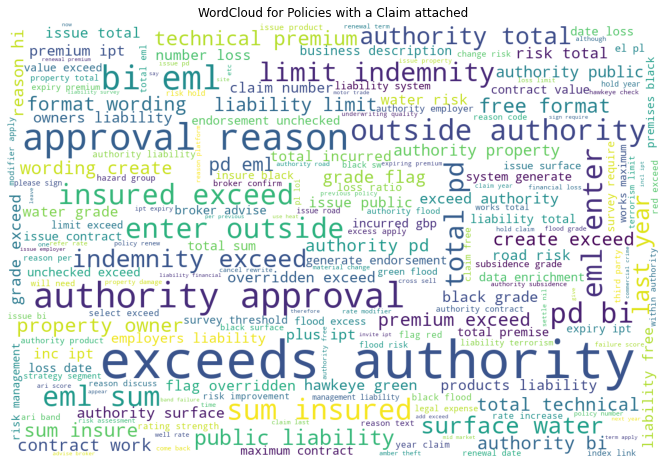

In [ ]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

claim_token =  [' '.join(x) for x in train[train["Claim"] == 'Yes'].text]


wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(claim_token)) 

plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title('WordCloud for Policies with a Claim attached')
#plt.tight_layout(pad = 0) 
  
plt.show()

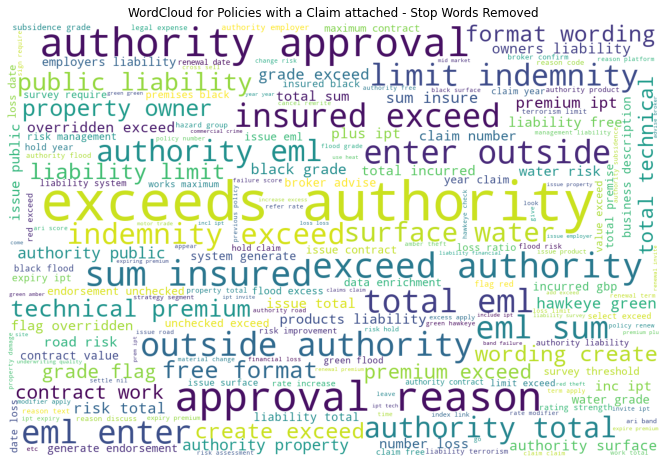

In [ ]:
%matplotlib inline

claim_token =  [' '.join(x) for x in train[train["Claim"] == 'Yes'].tokens]


wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(claim_token)) 

plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title('WordCloud for Policies with a Claim attached - Stop Words Removed')
#plt.tight_layout(pad = 0) 
  
plt.show()

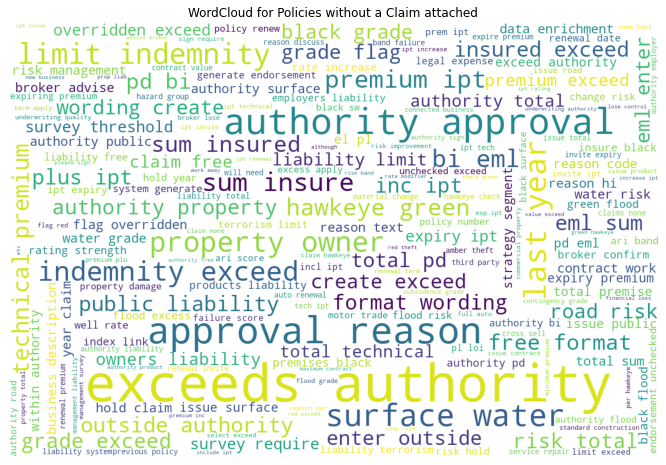

In [ ]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

non_claim_token =  [' '.join(x) for x in train[train["Claim"] == 'No'].text]

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(non_claim_token)) 

plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.title('WordCloud for Policies without a Claim attached')
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

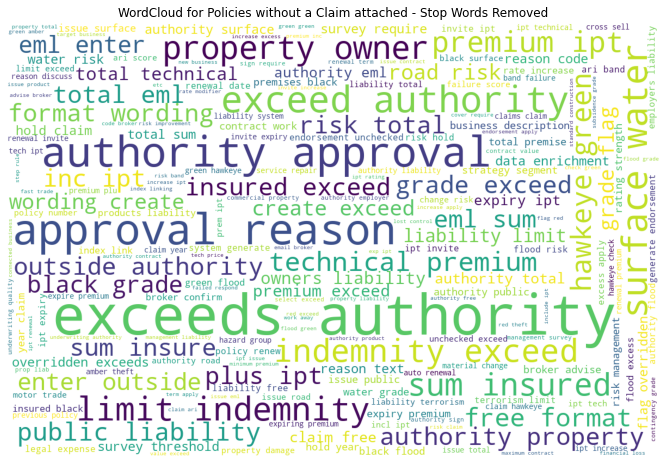

In [ ]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

non_claim_token =  [' '.join(x) for x in train[train["Claim"] == 'No'].tokens]

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(non_claim_token)) 

plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.title('WordCloud for Policies without a Claim attached - Stop Words Removed')
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
import statistics

In [ ]:
x = statistics.median([len(text) for text in preprocessed.clean.values])

In [ ]:
x

1660.5

In [ ]:
print(statistics.median(claim_length))

3168


In [ ]:
print(statistics.median(non_claim_length))

1409


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


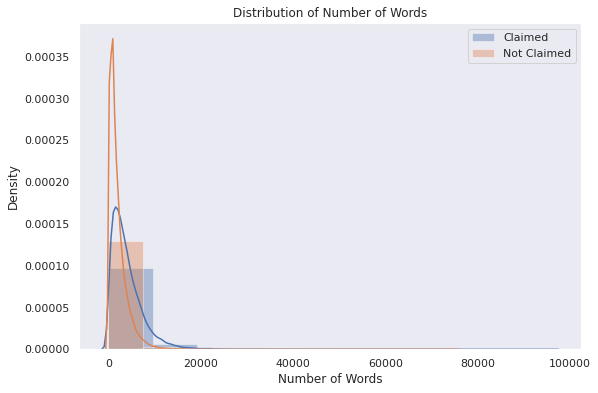

In [ ]:
%matplotlib inline

claim_length = [len(text) for text in preprocessed[preprocessed.Claim.values == 'Yes'].clean.values]
non_claim_length = [len(text) for text in preprocessed[preprocessed.Claim.values != 'Yes'].clean.values]

plt.figure(figsize = (9, 6)) 
sns.distplot(claim_length, bins = 10, label = 'Claimed')
sns.distplot(non_claim_length, bins = 10, label = 'Not Claimed')
plt.legend()
plt.title('Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


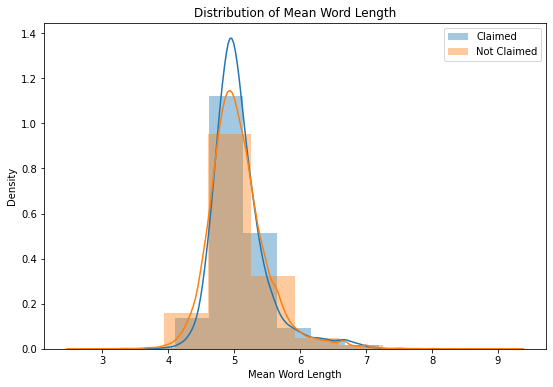

In [ ]:
def mean_word_length(x):
    word_lengths = np.array([])
    for word in (x):
        word_lengths = np.append(word_lengths, len(word))
    return word_lengths.mean()


claim_mean = train[train.Claim.values == 'Yes'].text.apply(mean_word_length)
non_claim_mean = train[train.Claim.values != 'Yes'].text.apply(mean_word_length)

plt.figure(figsize = (9, 6)) 
sns.distplot(claim_mean, bins = 10, label = 'Claimed')
sns.distplot(non_claim_mean, bins = 10, label = 'Not Claimed')
plt.title('Distribution of Mean Word Length')
plt.xlabel('Mean Word Length')
plt.legend()

In [ ]:
import nltk
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

In [ ]:
finder_no_claim = BigramCollocationFinder.from_documents(preprocessed.lemmas[preprocessed["Claim"] == 'No'])

In [ ]:
finder_no_claim.apply_freq_filter(3)
for i in range(0, 20):
  print(finder_no_claim.score_ngrams(BigramAssocMeasures.likelihood_ratio)[i])

(('exceeds', 'authority'), 2887353.2829039926)
(('approval', 'reason'), 1396966.9290524384)
(('surface', 'water'), 1071846.7123528805)
(('authority', 'approval'), 1020496.6050482786)
(('sign', 'off'), 952879.371256467)
(('last', 'year'), 700260.5247829284)
(('as', 'per'), 602477.2278307455)
(('indemnity', 'exceeds'), 539740.98914839)
(('sum', 'insure'), 538998.6506099098)
(('free', 'format'), 537140.8130178087)
(('of', 'indemnity'), 519185.5609944184)
(('format', 'wording'), 476227.6737573596)
(('property', 'owners'), 475005.9232000811)
(('bi', 'eml'), 461246.5466897187)
(('limit', 'of'), 441280.2118925104)
(('wording', 'create'), 437903.84806971566)
(('public', 'liability'), 413538.3026273978)
(('sum', 'insured'), 408324.68758389645)
(('pd', 'bi'), 387369.826871428)
(('eml', 'enter'), 386142.218663685)


In [ ]:
finder_claim = BigramCollocationFinder.from_documents(preprocessed.lemmas[preprocessed["Claim"] == 'Yes'])

In [ ]:
finder_claim.apply_freq_filter(3)
for i in range(0, 20):
  print(finder_claim.score_ngrams(BigramAssocMeasures.likelihood_ratio)[i])

(('exceeds', 'authority'), 1948721.7463686059)
(('approval', 'reason'), 968673.1779875214)
(('bi', 'eml'), 651449.7488744091)
(('authority', 'approval'), 632833.6877985866)
(('sign', 'off'), 521125.6913445497)
(('sum', 'insured'), 514160.34464877326)
(('eml', 'enter'), 493315.3090513409)
(('surface', 'water'), 484537.3810824292)
(('pd', 'bi'), 419776.20553700463)
(('eml', 'sum'), 398669.30151846126)
(('outside', 'authority'), 395704.27573517355)
(('free', 'format'), 370957.9165598543)
(('insured', 'exceeds'), 356074.29958386935)
(('total', 'pd'), 353736.3943959081)
(('of', 'indemnity'), 337758.8672836221)
(('format', 'wording'), 324808.0822322529)
(('last', 'year'), 316434.15650714125)
(('enter', 'be'), 315264.19991180836)
(('indemnity', 'exceeds'), 307607.2893773396)
(('be', 'outside'), 305046.3765367521)


# Bag of Words



In [ ]:
from gensim.corpora import Dictionary, HashDictionary, MmCorpus, WikiCorpus
from gensim.models import TfidfModel

In [ ]:
dct = Dictionary(train.tokens)
dct.filter_extremes(no_below = 100)
corpus = [dct.doc2bow(line) for line in train.tokens]

In [ ]:
dct_no_claim = Dictionary(train.tokens[train["Claim"] == 'No'])
dct_no_claim.filter_extremes(no_below = 1000)

In [ ]:
corpus_no_claim = [dct_no_claim.doc2bow(line) for line in train.tokens[train["Claim"] == 'No']]

In [ ]:
total_word_count_no_claims = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus_no_claim):
    total_word_count_no_claims[word_id] += word_count

In [ ]:
total_word_count_no_claims 

defaultdict(int,
            {0: 22805,
             1: 7878,
             2: 57710,
             3: 24749,
             4: 9708,
             5: 81714,
             6: 103252,
             7: 37329,
             8: 107467,
             9: 31965,
             10: 34017,
             11: 21175,
             12: 19851,
             13: 24703,
             14: 1360,
             15: 2749,
             16: 5612,
             17: 4982,
             18: 11059,
             19: 1579,
             20: 3788,
             21: 4420,
             22: 103984,
             23: 26933,
             24: 6870,
             25: 81679,
             26: 33552,
             27: 27934,
             28: 12838,
             29: 2168,
             30: 24126,
             31: 2899,
             32: 21140,
             33: 39680,
             34: 3339,
             35: 10691,
             36: 22310,
             37: 10377,
             38: 45607,
             39: 12349,
             40: 29813,
             41: 26

In [ ]:
df = pd.DataFrame.from_dict(total_word_count_no_claims , orient='index', columns=['Frequency'])

In [ ]:
df = df.sort_values(by='Frequency', ascending=False)

In [ ]:
df = df.head(25)

In [ ]:
df

,Frequency
175,181569
152,132801
283,131690
118,117421
319,108700
143,108334
8,107467
160,104826
22,103984
6,103252


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
words_no_claims = pd.DataFrame([dct_no_claim[175], dct_no_claim[152], dct_no_claim[283], dct_no_claim[118], dct_no_claim[319], dct_no_claim[143], dct_no_claim[8], dct_no_claim[160], dct_no_claim[22], dct_no_claim[6],
                      dct_no_claim[98], dct_no_claim[51], dct_no_claim[90], dct_no_claim[303], dct_no_claim[304], dct_no_claim[47], dct_no_claim[298], dct_no_claim[123], dct_no_claim[5], dct_no_claim[25],
                      dct_no_claim[116], dct_no_claim[162], dct_no_claim[218], dct_no_claim[134], dct_no_claim[417]],
                      columns = ['Word'])

In [ ]:
df2 = pd.concat([df, words_no_claims], axis=1, ignore_index=True)

In [ ]:
symbols = ['Frequency', 'Words']

df2.columns = symbols

In [ ]:
df2

,Frequency,Words
0,181569,exceeds
1,132801,property
2,131690,liability
3,117421,survey
4,108700,total
5,108334,flood
6,107467,apply
7,104826,approval
8,103984,change
9,103252,agree


In [ ]:
dct_claim = Dictionary(train.tokens[train["Claim"] == 'Yes'])
dct_claim.filter_extremes(no_below = 100)

In [ ]:
corpus_claim = [dct_claim.doc2bow(line) for line in train.tokens[train["Claim"] == 'Yes']]

In [ ]:
total_word_count_claims = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus_claim):
    total_word_count_claims[word_id] += word_count

In [ ]:
df3 = pd.DataFrame.from_dict(total_word_count_claims , orient='index', columns=['Frequency'])

In [ ]:
df3 = df3.sort_values(by='Frequency', ascending=False)

In [ ]:
df3 = df3.head(25)

In [ ]:
df3

,Frequency
103,101673
188,55903
115,48827
403,45447
429,44615
776,42449
76,41154
196,40356
363,40243
303,39061


In [ ]:
df3 = df3.reset_index(drop=True)

In [ ]:
words_claims = pd.DataFrame([dct_claim[103], dct_claim[188], dct_claim[115], dct_claim[403], dct_claim[429], dct_claim[776], dct_claim[76], dct_claim[196], dct_claim[363], dct_claim[303],
                      dct_claim[161], dct_claim[358], dct_claim[408], dct_claim[38], dct_claim[331], dct_claim[373], dct_claim[220], dct_claim[6], dct_claim[166], dct_claim[102],
                      dct_claim[116], dct_claim[391], dct_claim[336], dct_claim[96], dct_claim[377]],
                      columns = ['Word'])

In [ ]:
df4 = pd.concat([df3, words_claims], axis=1, ignore_index=True)

In [ ]:
symbols = ['Frequency', 'Words']

df4.columns = symbols

In [ ]:
df4

,Frequency,Words
0,101673,eml
1,55903,limit
2,48827,exceed
3,45447,flood
4,44615,outside
5,42449,enter
6,41154,contract
7,40356,loss
8,40243,work
9,39061,sign


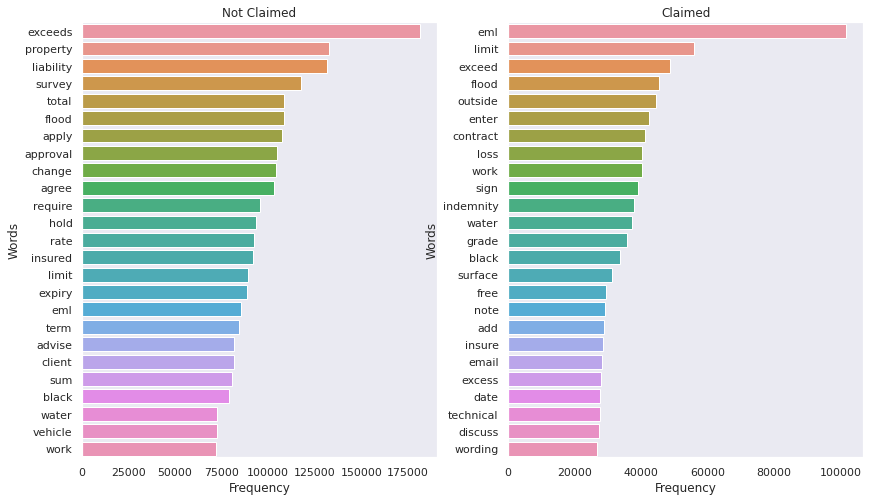

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(14, 8))
sns.barplot(y="Words", x="Frequency", data=df2, ax=ax[0])
sns.barplot(y="Words", x="Frequency", data=df4, ax=ax[1])
ax[0].set_title('Not Claimed')
ax[1].set_title('Claimed')
fig.show()

# Term Frequency - Inverse Docuement Frequency

In [ ]:
model = TfidfModel(corpus)
scores = model[corpus]

In [ ]:
scores_no_claim = model[corpus_no_claim]

In [ ]:
# Define a dictionary ``td`` where each document gather
td_no_claim = { 
    dct_no_claim.get(_id): value for doc in scores_no_claim
    for _id, value in doc
    }

# Sort the items of ``td`` into a new variable ``sorted_td``
# the ``reverse`` starts from highest to lowest
sorted_td_no_claim = sorted(td_no_claim.items(), key=lambda kv: kv[1], reverse=True) 

In [ ]:
sorted_td_no_claim = pd.DataFrame(sorted_td_no_claim[0:25], columns=['Word','Weight'])

In [ ]:
sorted_td_no_claim

,Word,Weight
0,event,0.714110
1,contract,0.591481
2,chaser,0.572254
3,minimum,0.561213
4,lose,0.548638
5,eml,0.456926
6,smith,0.428124
7,send,0.422894
8,helen,0.419440
9,main,0.381573


In [ ]:
scores_claim = model[corpus_claim]

In [ ]:
# Define a dictionary ``td`` where each document gather
td_claim = { 
    dct_claim.get(_id): value for doc in scores_claim
    for _id, value in doc
    }

# Sort the items of ``td`` into a new variable ``sorted_td``
# the ``reverse`` starts from highest to lowest
sorted_td_claim = sorted(td_claim.items(), key=lambda kv: kv[1], reverse=True) 

In [ ]:
sorted_td_claim = pd.DataFrame(sorted_td_claim[0:25], columns=['Word','Weight'])

In [ ]:
sorted_td_claim

,Word,Weight
0,bike,0.807633
1,eml,0.748382
2,mill,0.549091
3,railway,0.511845
4,outside,0.471563
5,owners,0.466303
6,demo,0.463919
7,rt,0.452429
8,caravan,0.449811
9,consolidation,0.446012


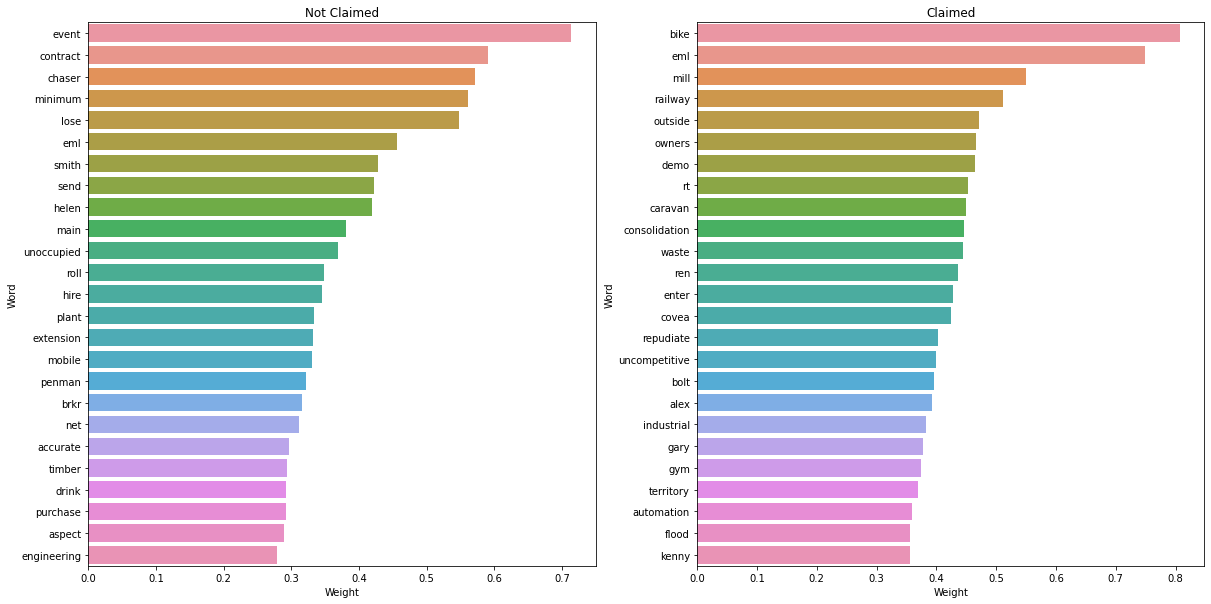

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20, 10))
sns.barplot(y="Word", x="Weight", data=sorted_td_no_claim, ax=ax[0])
sns.barplot(y="Word", x="Weight", data=sorted_td_claim, ax=ax[1])
ax[0].set_title('Not Claimed')
ax[1].set_title('Claimed')
fig.show()

# Embeddings


In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=-1)

In [ ]:
t = time()

w2v_model.build_vocab(train['tokens'], progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.17 mins


In [ ]:
t = time()

w2v_model.train(train['tokens'], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.11 mins


In [ ]:
w2v_model.init_sims(replace=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(w2v_model)

In [ ]:
def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

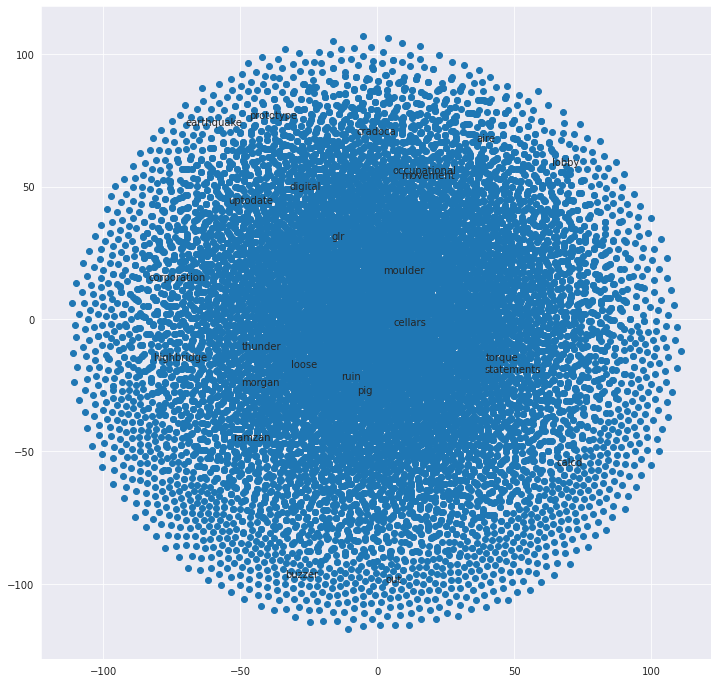

In [ ]:
plot_with_matplotlib(x_vals, y_vals, labels)

In [ ]:
import gensim.downloader as api

In [ ]:
model = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
x_vals, y_vals, labels = reduce_dimensions(w2v_model)

In [ ]:
nlp = spacy.load('en_vectors_web_lg')

In [ ]:
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


In [ ]:
unique_words  = set()
train['tokens'].apply(unique_words.update)

82680     None
41722     None
123984    None
41437     None
38159     None
          ... 
143895    None
84506     None
4506      None
116558    None
69712     None
Name: tokens, Length: 120521, dtype: object

In [ ]:
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
questioonaire,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
walks,0.39896,0.015741,-0.484010,0.078445,0.326400,0.50727,-0.521250,-0.004235,0.33273,2.5510,0.003514,-0.078143,-0.74559,-0.096669,-0.078546,0.568050,0.053679,0.171360,-0.33194,-0.29441,-0.704600,0.25513,-0.128320,0.15155,0.409970,0.068782,0.792400,-0.26620,-0.268470,-0.195340,-0.21618,-0.18410,-0.42040,-0.301510,0.260330,-0.004598,0.51002,-0.55747,-0.014522,0.218630,...,-0.20384,0.518950,0.252050,-0.489310,0.631480,0.243740,0.274750,-0.37062,-0.109910,0.19688,-1.255100,-0.225960,0.22247,0.016926,0.116080,0.41003,0.358040,-0.13336,-0.059398,-0.21426,0.210670,0.229990,-0.382180,0.41690,0.004752,-0.204300,0.012356,0.114100,0.11100,0.153560,0.35111,-0.254260,-0.17274,-0.064054,-0.199990,-0.14367,0.882750,0.268610,0.33279,-0.390160
homecare,0.39631,0.090738,-0.017317,-0.395560,-0.134290,-0.70423,0.215090,0.164680,0.16534,0.3944,0.104340,0.421880,0.31218,0.497060,0.619300,0.251440,1.173300,0.062608,0.14168,-0.70878,-0.013481,0.29917,0.341790,-0.36431,0.466380,0.256560,-0.377140,0.16890,1.185100,0.369850,0.52596,-0.22941,-0.13574,-0.172580,0.307760,0.407530,-0.35196,-0.50080,-0.363410,0.194060,...,-0.64619,0.436690,0.058456,-0.236560,0.154220,0.144990,-0.004624,-0.13651,-0.671700,0.29462,-0.290090,0.017304,0.10732,0.410020,-0.483860,0.40205,-0.011069,0.80928,0.593720,-0.28276,-0.172260,0.252850,0.392560,0.31385,-0.154650,-0.344800,-0.256620,0.348170,0.49013,0.101990,0.69507,-0.123810,0.02014,0.037608,0.088828,-0.99720,0.378220,-0.413100,-0.71756,-0.003431
thoguh,0.25341,-0.079483,-0.143400,-0.530350,-0.056728,0.17300,-0.086216,-0.453860,0.17864,-1.1603,0.211480,0.377820,0.19023,-0.010171,-0.031939,0.164100,0.042236,-1.790500,0.28632,-0.19050,0.184220,0.36901,0.124900,-0.50414,-0.001001,-0.189080,-0.187580,-0.44887,0.322540,-0.098349,0.33124,-0.48256,0.15461,-0.033044,-0.197980,0.062405,0.19606,0.29874,-0.070821,-0.094322,...,0.19966,0.089673,-0.018396,0.045077,-0.269490,0.052188,-0.106900,0.24674,-0.008538,0.50767,-0.171210,-0.094005,0.16135,-0.234200,-0.209720,0.54052,-0.151630,-0.10294,-0.007830,-0.21886,0.035563,-0.526550,0.062684,-0.19571,0.120970,0.258710,0.056757,0.323450,-0.12130,-0.215140,0.40638,-0.402290,-0.26098,-0.101790,0.106860,0.15932,-0.033862,0.029382,0.23079,0.159420
reneweda,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

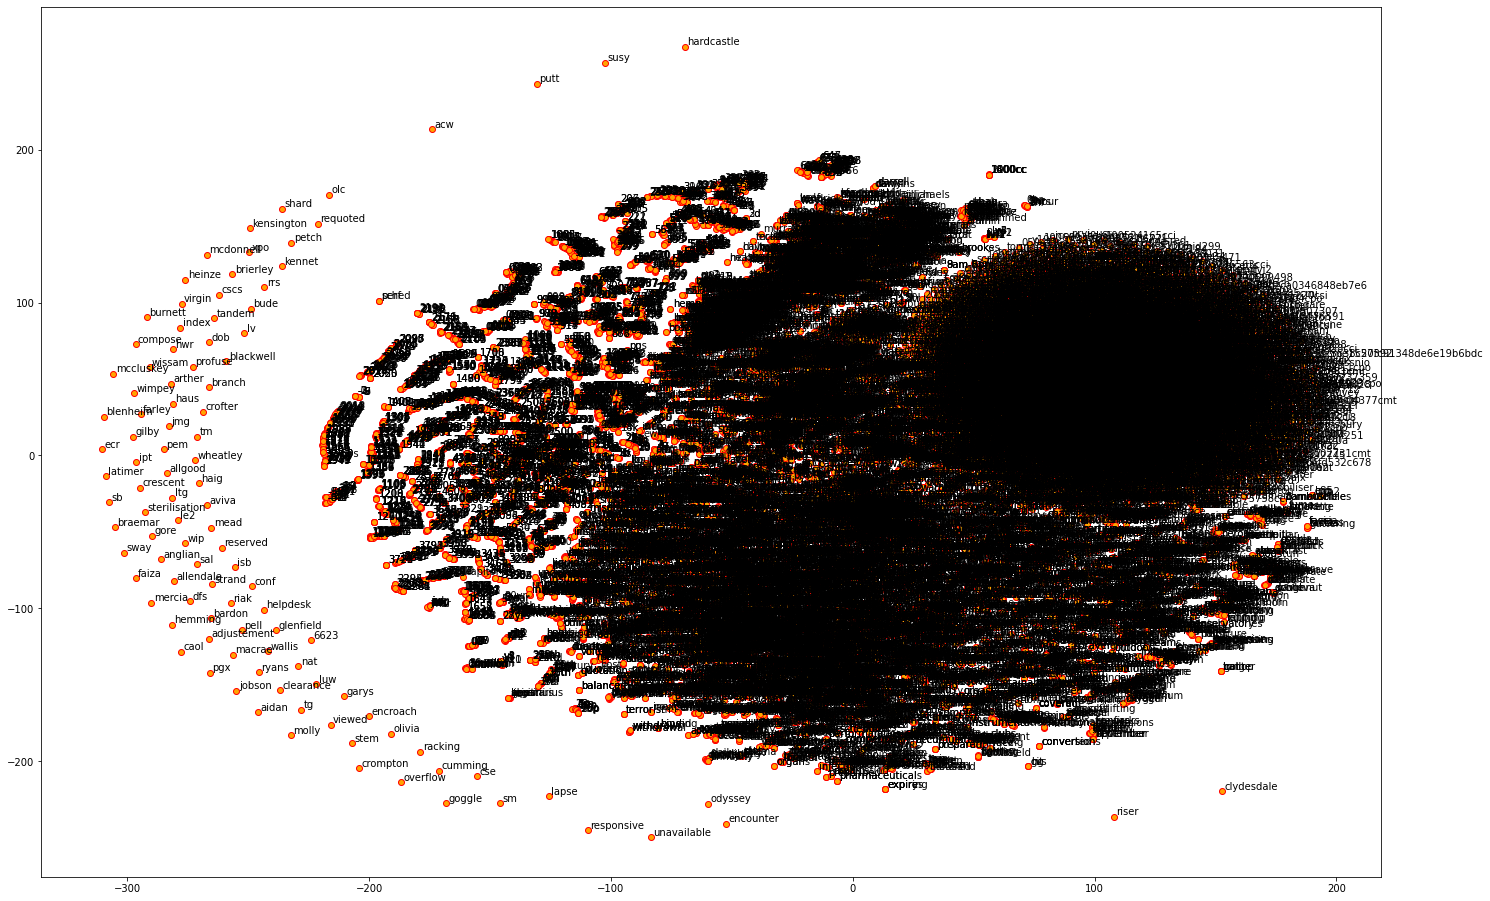

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(24, 16))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in train['tokens']])

km = KMeans(n_clusters=2, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])

In [ ]:
pd.concat([train, cluster_labels], axis=1)

,text,Claim,tokens,Product_Code,POLICYID,ClusterLabel
82680,"[trade, since, specialise, in, clutch, gearbox...",No,"[trading, specialise, clutch, gearbox, mechani...",CMT,401354038,0
41722,"[claim, hold, since, ari, hawkeye, green, cont...",No,"[claim, hold, ari, hawkeye, green, contingenci...",CCI,401175001,0
123984,"[policy, hold, since, pays, by, gacs, charge, ...",Yes,"[policy, hold, pay, gacs, charge, claim, theft...",CSI,401119624,0
41437,"[hold, since, claim, portfolio, of, residentia...",No,"[hold, claims, portfolio, residential, flat, u...",CPO,401174498,0
38159,"[policy, be, conversion, of, 24704588cci, at, ...",No,"[policy, conversion, renewal, previous, policy...",CCI,401169020,0
...,...,...,...,...,...,...
143895,"[issue, bi, eml, enter, be, outside, authority...",Yes,"[issue, eml, enter, outside, authority, total,...",PML,401351210,1
84506,"[policy, renew, ipt, see, document, for, ratio...",No,"[policy, renew, ipt, document, rationale, corr...",CPO,401356936,1
4506,"[speak, to, peter, brk, dec, on, way, off, fro...",No,"[spoke, peter, brk, dec, way, need, term, fri,...",CMT,401110006,0
116558,"[quote, receive, from, key, partner, broker, h...",No,"[quote, receive, key, partner, broker, hold, m...",CCI,401590416,0


# Many Claims


In [ ]:
dct_many_claims = Dictionary(train.tokens[train["Number_of_Claims"] > 1])
dct_many_claims.filter_extremes(no_below = 10)

In [ ]:
corpus_many_claims = [dct_many_claims.doc2bow(line) for line in train.tokens[train["Number_of_Claims"] > 1]]

In [ ]:
total_word_many_claims = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus_many_claims):
    total_word_many_claims[word_id] += word_count

In [ ]:
total_word_many_claims 

In [ ]:
df_many_claims = pd.DataFrame.from_dict(total_word_many_claims, orient='index', columns=['Frequency'])

In [ ]:
df_many_claims = df_many_claims.sort_values(by='Frequency', ascending=False)

In [ ]:
df_many_claims = df_many_claims.head(25)

In [ ]:
df_many_claims

,Frequency
53,71777
328,32663
321,31477
233,29875
218,26263
305,22741
298,22197
775,21029
341,19106
323,18818


In [ ]:
words_many_claims = pd.DataFrame([dct_many_claims[53], dct_many_claims[328], dct_many_claims[321], dct_many_claims[233], dct_many_claims[218], dct_many_claims[305], dct_many_claims[298], dct_many_claims[775], dct_many_claims[341], dct_many_claims[323],
                      dct_many_claims[67], dct_many_claims[312], dct_many_claims[746], dct_many_claims[309], dct_many_claims[337], dct_many_claims[52], dct_many_claims[175], dct_many_claims[2], dct_many_claims[92], dct_many_claims[61],
                      dct_many_claims[304], dct_many_claims[107], dct_many_claims[264], dct_many_claims[554], dct_many_claims[301]],
                      columns = ['Word'])

In [ ]:
df_many_claims = df_many_claims.reset_index(drop=True)

In [ ]:
df_many_claims = pd.concat([df_many_claims, words_many_claims], axis=1, ignore_index=True)

In [ ]:
symbols = ['Frequency', 'Words']

df_many_claims.columns = symbols

In [ ]:
df_many_claims

,Frequency,Words
0,71777,eml
1,32663,outside
2,31477,enter
3,29875,exceed
4,26263,contract
5,22741,indemnity
6,22197,work
7,21029,flood
8,19106,water
9,18818,grade


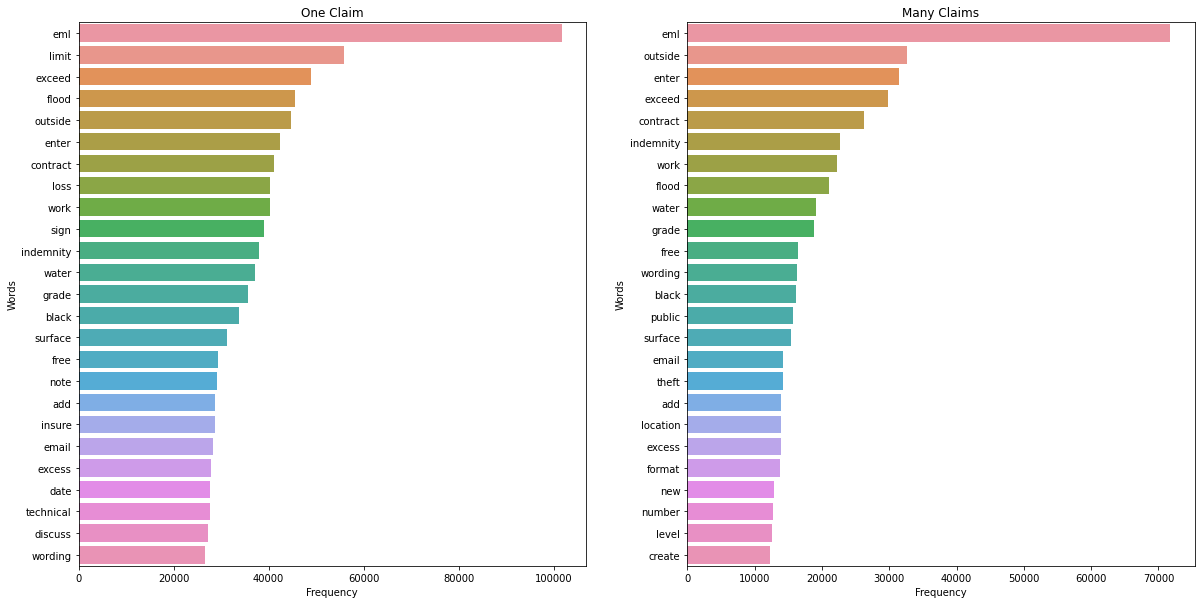

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20, 10))
sns.barplot(y="Words", x="Frequency", data=df4, ax=ax[0])
sns.barplot(y="Words", x="Frequency", data=df_many_claims, ax=ax[1])
ax[0].set_title('One Claim')
ax[1].set_title('Many Claims')
fig.show()

In [ ]:
model_many_claims = TfidfModel(corpus_many_claims)

In [ ]:
scores_many_claims = model_many_claims[corpus_many_claims]

In [ ]:
# Define a dictionary ``td`` where each document gather
td_many_claims = { 
    dct_many_claims.get(_id): value for doc in scores_many_claims
    for _id, value in doc
    }

# Sort the items of ``td`` into a new variable ``sorted_td``
# the ``reverse`` starts from highest to lowest
sorted_many_claims = sorted(td_many_claims.items(), key=lambda kv: kv[1], reverse=True) 

In [ ]:
sorted_many_claims = pd.DataFrame(sorted_many_claims[0:25], columns=['Word','Weight'])

In [ ]:
sorted_many_claims

,Word,Weight
0,broadway,0.829121
1,bordereaux,0.798351
2,eml,0.774466
3,railway,0.739989
4,steven,0.712665
5,hospice,0.689791
6,goodman,0.680324
7,haus,0.677899
8,inlcude,0.677654
9,meadows,0.674712


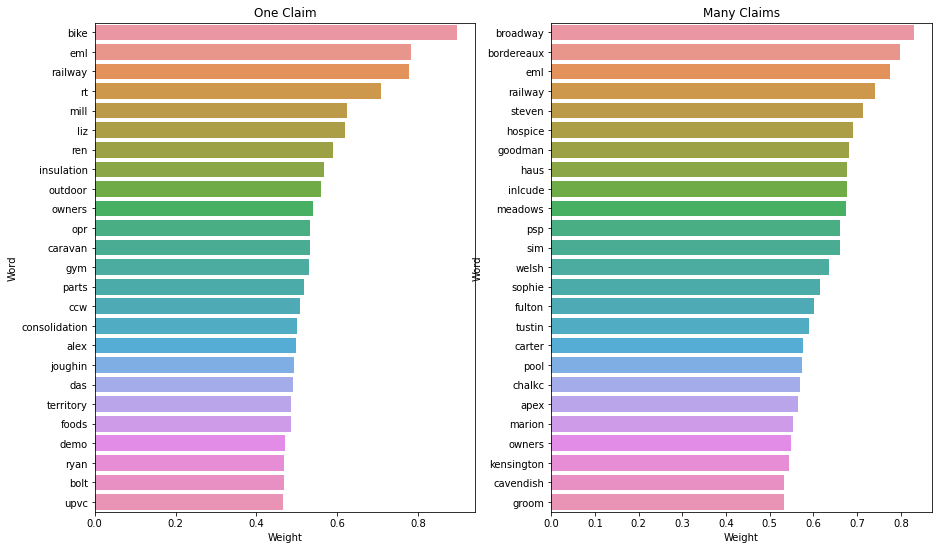

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(15, 9))
sns.barplot(y="Word", x="Weight", data=sorted_td_claim, ax=ax[0])
sns.barplot(y="Word", x="Weight", data=sorted_many_claims, ax=ax[1])
ax[0].set_title('One Claim')
ax[1].set_title('Many Claims')
fig.show()

# Product Code Analysis - CCI



In [ ]:
CCI = train[train.Product_Code == 'CCI']
CCI.head()

,text,Claim,Number_of_Claims,tokens,Product_Code,POLICYID
41722,"[claim, hold, since, ari, hawkeye, green, cont...",No,0,"[claim, hold, ari, hawkeye, green, contingenci...",CCI,401175001
38159,"[policy, be, conversion, of, 24704588cci, at, ...",No,0,"[policy, conversion, renewal, previous, policy...",CCI,401169020
8353,"[hold, risk, since, never, have, claim, hawkey...",No,0,"[hold, risk, claim, hawkeye, check, green, mig...",CCI,401117217
22643,"[issue, products, liability, system, generate,...",No,0,"[issue, products, liability, system, generate,...",CCI,401143333
35286,"[be, do, as, favour, to, bluefin, and, expiry,...",No,0,"[favour, bluefin, expiry, premium, claim, agre...",CCI,401164360


In [ ]:
dct_CCI = Dictionary(CCI.tokens)
dct_CCI.filter_extremes(no_below = 10)

In [ ]:
corpus_CCI = [dct_CCI.doc2bow(line) for line in CCI.tokens]

In [ ]:
total_word_CCI = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus_CCI):
    total_word_CCI[word_id] += word_count

In [ ]:
total_word_CCI 

defaultdict(int,
            {0: 33004,
             1: 838,
             2: 23432,
             3: 480,
             4: 4574,
             5: 1668,
             6: 11391,
             7: 35,
             8: 64388,
             9: 1930,
             10: 1086,
             11: 4426,
             12: 543,
             13: 22832,
             14: 22899,
             15: 4565,
             16: 18132,
             17: 13902,
             18: 41353,
             19: 56655,
             20: 33692,
             21: 54670,
             22: 5235,
             23: 1942,
             24: 11647,
             25: 22198,
             26: 3588,
             27: 5024,
             28: 3234,
             29: 15094,
             30: 27653,
             31: 5824,
             32: 9472,
             33: 2616,
             34: 41797,
             35: 578,
             36: 21848,
             37: 18527,
             38: 87,
             39: 5304,
             40: 311,
             41: 24408,
             42:

In [ ]:
df = pd.DataFrame.from_dict(total_word_CCI , orient='index', columns=['Frequency'])

In [ ]:
df = df.sort_values(by='Frequency', ascending=False)

In [ ]:
df = df.head(25)

In [ ]:
df

,Frequency
167,121901
229,71697
8,64388
179,62848
162,62198
184,60890
19,56655
127,55350
166,54937
21,54670


In [ ]:
words_CCI = pd.DataFrame([dct_CCI[167], dct_CCI[229], dct_CCI[8], dct_CCI[179], dct_CCI[162], dct_CCI[184], dct_CCI[19], dct_CCI[127], dct_CCI[166], dct_CCI[21],
                      dct_CCI[353], dct_CCI[148], dct_CCI[143], dct_CCI[63], dct_CCI[176], dct_CCI[1120], dct_CCI[130], dct_CCI[34], dct_CCI[472], dct_CCI[18],
                      dct_CCI[171], dct_CCI[1119], dct_CCI[82], dct_CCI[193], dct_CCI[70]],
                      columns = ['Word'])

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df = pd.concat([df, words_CCI], axis=1, ignore_index=True)

In [ ]:
symbols = ['Frequency', 'Words']

df.columns = symbols

In [ ]:
dct_CCI_Claim = Dictionary(CCI.tokens[CCI["Claim"] == 'Yes'])
dct_CCI_Claim.filter_extremes(no_below = 10)

In [ ]:
corpus_CCI_Claim = [dct_CCI_Claim.doc2bow(line) for line in CCI.tokens[CCI["Claim"] == 'Yes']]

In [ ]:
total_word_CCI_Claim = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus_CCI_Claim):
    total_word_CCI_Claim[word_id] += word_count

In [ ]:
df_claim = pd.DataFrame.from_dict(total_word_CCI_Claim , orient='index', columns=['Frequency'])

In [ ]:
df_claim = df_claim.sort_values(by='Frequency', ascending=False)

In [ ]:
df_claim = df_claim.head(25)

In [ ]:
df_claim

,Frequency
594,33922
86,26375
53,23885
63,20894
76,18876
9,16457
380,15599
553,15052
25,14928
69,13785


In [ ]:
words_CCI_claim = pd.DataFrame([dct_CCI_Claim[594], dct_CCI_Claim[86], dct_CCI_Claim[53], dct_CCI_Claim[63], dct_CCI_Claim[76], dct_CCI_Claim[9], dct_CCI_Claim[380], dct_CCI_Claim[553], dct_CCI_Claim[25], dct_CCI_Claim[69],
                      dct_CCI_Claim[541], dct_CCI_Claim[7], dct_CCI_Claim[305], dct_CCI_Claim[223], dct_CCI_Claim[186], dct_CCI_Claim[182], dct_CCI_Claim[261], dct_CCI_Claim[14], dct_CCI_Claim[84], dct_CCI_Claim[557],
                      dct_CCI_Claim[54], dct_CCI_Claim[225], dct_CCI_Claim[5], dct_CCI_Claim[12], dct_CCI_Claim[248]],
                      columns = ['Word'])

In [ ]:
df_claim = df_claim.reset_index(drop=True)

In [ ]:
df_claim = pd.concat([df_claim, words_CCI_claim], axis=1, ignore_index=True)

In [ ]:
symbols = ['Frequency', 'Words']

df_claim.columns = symbols

In [ ]:
dct_CCI_No_Claim = Dictionary(CCI.tokens[CCI["Claim"] == 'No'])
dct_CCI_No_Claim.filter_extremes(no_below = 10)

In [ ]:
corpus_CCI_No_Claim = [dct_CCI_No_Claim.doc2bow(line) for line in CCI.tokens[CCI["Claim"] == 'No']]

In [ ]:
total_word_CCI_No_Claim = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus_CCI_No_Claim):
    total_word_CCI_No_Claim[word_id] += word_count

In [ ]:
df_no_claim = pd.DataFrame.from_dict(total_word_CCI_No_Claim , orient='index', columns=['Frequency'])

In [ ]:
df_no_claim = df_no_claim.sort_values(by='Frequency', ascending=False)

In [ ]:
df_no_claim = df_no_claim.head(25)

In [ ]:
df_no_claim

,Frequency
173,68024
190,66659
30,47377
144,44040
39,43549
8,43494
45,42925
142,40887
20,38829
236,38392


In [ ]:
words_CCI_no_claim = pd.DataFrame([dct_CCI_No_Claim[173], dct_CCI_No_Claim[190], dct_CCI_No_Claim[30], dct_CCI_No_Claim[144], dct_CCI_No_Claim[39], dct_CCI_No_Claim[8], dct_CCI_No_Claim[45], dct_CCI_No_Claim[142], dct_CCI_No_Claim[20], dct_CCI_No_Claim[236],
                      dct_CCI_No_Claim[22], dct_CCI_No_Claim[9], dct_CCI_No_Claim[185], dct_CCI_No_Claim[67], dct_CCI_No_Claim[191], dct_CCI_No_Claim[154], dct_CCI_No_Claim[149], dct_CCI_No_Claim[131], dct_CCI_No_Claim[172], dct_CCI_No_Claim[359],
                      dct_CCI_No_Claim[134], dct_CCI_No_Claim[950], dct_CCI_No_Claim[168], dct_CCI_No_Claim[36], dct_CCI_No_Claim[948]],
                      columns = ['Word'])

In [ ]:
df_no_claim = df_no_claim.reset_index(drop=True)

In [ ]:
df_no_claim = pd.concat([df_no_claim, words_CCI_no_claim], axis=1, ignore_index=True)

In [ ]:
symbols = ['Frequency', 'Words']

df_no_claim.columns = symbols

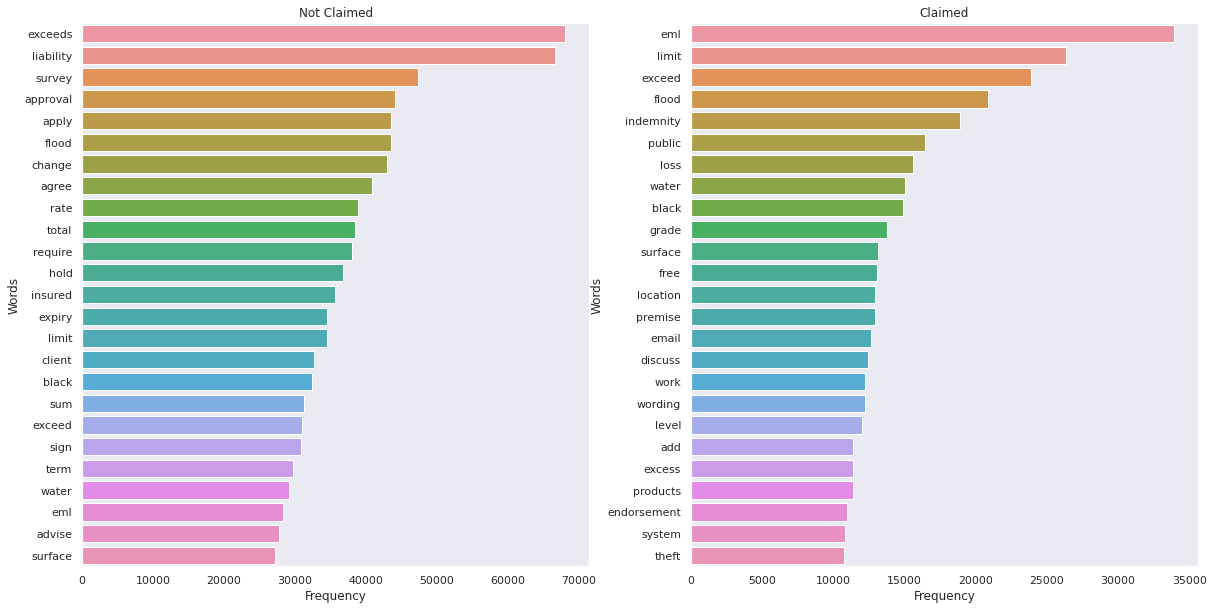

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20, 10))
sns.barplot(y="Words", x="Frequency", data=df_no_claim, ax=ax[0])
sns.barplot(y="Words", x="Frequency", data=df_claim, ax=ax[1])
ax[0].set_title('Not Claimed')
ax[1].set_title('Claimed')
fig.show()

In [ ]:
scores_CCI_no_claim = model[corpus_CCI_No_Claim]

NameError: ignored

In [ ]:
# Define a dictionary ``td`` where each document gather
td_CCI_no_claim = { 
    dct_CCI_No_Claim.get(_id): value for doc in scores_CCI_no_claim
    for _id, value in doc
    }

# Sort the items of ``td`` into a new variable ``sorted_td``
# the ``reverse`` starts from highest to lowest
sorted_td_CCI_no_claim = sorted(td_CCI_no_claim.items(), key=lambda kv: kv[1], reverse=True) 

In [ ]:
sorted_td_CCI_no_claim = pd.DataFrame(sorted_td_CCI_no_claim[0:25], columns=['Word','Weight'])

In [ ]:
scores_CCI_claim = model[corpus_CCI_Claim]

In [ ]:
# Define a dictionary ``td`` where each document gather
td_CCI_claim = { 
    dct_CCI_Claim.get(_id): value for doc in scores_CCI_claim
    for _id, value in doc
    }

# Sort the items of ``td`` into a new variable ``sorted_td``
# the ``reverse`` starts from highest to lowest
sorted_CCI_td_claim = sorted(td_CCI_claim.items(), key=lambda kv: kv[1], reverse=True) 

In [ ]:
sorted_CCI_td_claim = pd.DataFrame(sorted_CCI_td_claim[0:25], columns=['Word','Weight'])

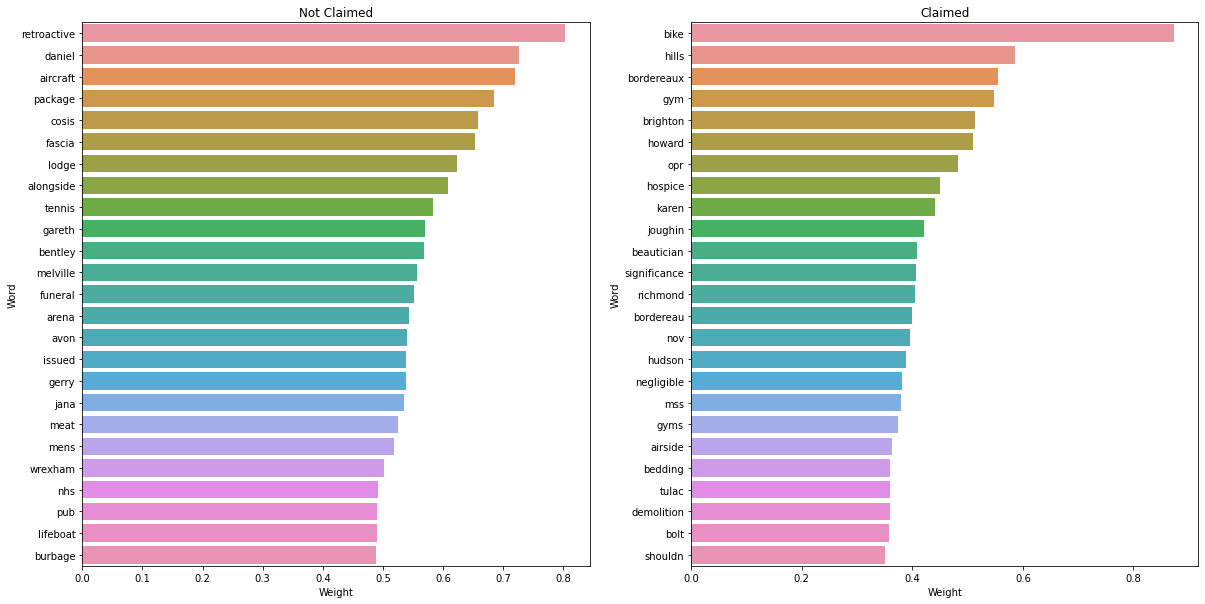

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20, 10))
sns.barplot(y="Word", x="Weight", data=sorted_td_CCI_no_claim, ax=ax[0])
sns.barplot(y="Word", x="Weight", data=sorted_CCI_td_claim, ax=ax[1])
ax[0].set_title('Not Claimed')
ax[1].set_title('Claimed')
fig.show()

# Product Code Analysis - CPO



In [ ]:
CPO = train[train.Product_Code == 'CPO']
CPO.head()

,text,Claim,Number_of_Claims,tokens,Product_Code,POLICYID
41437,"[hold, since, claim, portfolio, of, residentia...",No,0,"[hold, claims, portfolio, residential, flat, u...",CPO,401174498
49648,"[hold, year, claims, ari, risk, band, connecte...",No,0,"[hold, year, claims, ari, risk, band, connecte...",CPO,401188216
57208,"[issue, bi, eml, enter, be, outside, authority...",No,0,"[issue, eml, enter, outside, authority, eml, e...",CPO,401199769
2668,"[hawkeye, include, accumulation, check, requir...",No,0,"[hawkeye, include, accumulation, check, requir...",CPO,401104198
95353,"[let, content, policy, incepte, in, under, pol...",No,0,"[let, content, policy, incepte, policy, number...",CPO,401384680


In [ ]:
dct_CPO = Dictionary(CPO.tokens)
dct_CPO.filter_extremes(no_below = 10)

In [ ]:
corpus_CPO = [dct_CPO.doc2bow(line) for line in CPO.tokens]

In [ ]:
total_word_CPO = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus_CPO):
    total_word_CPO[word_id] += word_count

In [ ]:
total_word_CPO 

In [ ]:
df = pd.DataFrame.from_dict(total_word_CPO, orient='index', columns=['Frequency'])

In [ ]:
df = df.sort_values(by='Frequency', ascending=False)

In [ ]:
df = df.head(25)

In [ ]:
words_CPO = pd.DataFrame([dct_CPO[35], dct_CPO[163], dct_CPO[201], dct_CPO[111], dct_CPO[195], dct_CPO[133], dct_CPO[51], dct_CPO[44], dct_CPO[123], dct_CPO[193],
                      dct_CPO[172], dct_CPO[70], dct_CPO[47], dct_CPO[7], dct_CPO[174], dct_CPO[6], dct_CPO[3], dct_CPO[109], dct_CPO[52], dct_CPO[165],
                      dct_CPO[12], dct_CPO[38], dct_CPO[101], dct_CPO[98], dct_CPO[186]],
                      columns = ['Word'])

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df = pd.concat([df, words_CPO], axis=1, ignore_index=True)

In [ ]:
symbols = ['Frequency', 'Words']

df.columns = symbols

In [ ]:
df

,Frequency,Words
0,86111,exceeds
1,67380,eml
2,63218,total
3,56380,year
4,51674,survey
5,51449,liability
6,50741,increase
7,49740,flood
8,48473,cover
9,48365,sum


In [ ]:
dct_CPO_Claim = Dictionary(CPO.tokens[CPO["Claim"] == 'Yes'])
dct_CPO_Claim.filter_extremes(no_below = 10)

In [ ]:
corpus_CPO_Claim = [dct_CPO_Claim.doc2bow(line) for line in CPO.tokens[CPO["Claim"] == 'Yes']]

In [ ]:
total_word_CPO_Claim = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus_CPO_Claim):
    total_word_CPO_Claim[word_id] += word_count

In [ ]:
df_claim = pd.DataFrame.from_dict(total_word_CPO_Claim , orient='index', columns=['Frequency'])

In [ ]:
df_claim = df_claim.sort_values(by='Frequency', ascending=False)

In [ ]:
df_claim = df_claim.head(25)

In [ ]:
df_claim

,Frequency
27,38244
126,18280
120,17947
168,16065
42,14257
74,13896
107,13186
37,12830
54,12561
151,12079


In [ ]:
words_CPO_claim = pd.DataFrame([dct_CPO_Claim[27], dct_CPO_Claim[126], dct_CPO_Claim[120], dct_CPO_Claim[168], dct_CPO_Claim[42], dct_CPO_Claim[74], dct_CPO_Claim[107], dct_CPO_Claim[37], dct_CPO_Claim[54], dct_CPO_Claim[151],
                      dct_CPO_Claim[160], dct_CPO_Claim[93], dct_CPO_Claim[208], dct_CPO_Claim[21], dct_CPO_Claim[99], dct_CPO_Claim[289], dct_CPO_Claim[12], dct_CPO_Claim[84], dct_CPO_Claim[35], dct_CPO_Claim[171],
                      dct_CPO_Claim[86], dct_CPO_Claim[31], dct_CPO_Claim[33], dct_CPO_Claim[45], dct_CPO_Claim[98]],
                      columns = ['Word'])

In [ ]:
df_claim = df_claim.reset_index(drop=True)

In [ ]:
df_claim = pd.concat([df_claim, words_CPO_claim], axis=1, ignore_index=True)

In [ ]:
symbols = ['Frequency', 'Words']

df_claim.columns = symbols

In [ ]:
dct_CPO_No_Claim = Dictionary(CPO.tokens[CPO["Claim"] == 'No'])
dct_CPO_No_Claim.filter_extremes(no_below = 10)

In [ ]:
corpus_CPO_No_Claim = [dct_CPO_No_Claim.doc2bow(line) for line in CPO.tokens[CPO["Claim"] == 'No']]

In [ ]:
total_word_CPO_No_Claim = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus_CPO_No_Claim):
    total_word_CPO_No_Claim[word_id] += word_count

In [ ]:
df_no_claim = pd.DataFrame.from_dict(total_word_CPO_No_Claim , orient='index', columns=['Frequency'])

In [ ]:
df_no_claim = df_no_claim.sort_values(by='Frequency', ascending=False)

In [ ]:
df_no_claim = df_no_claim.head(25)

In [ ]:
df_no_claim

,Frequency
35,50340
111,39384
123,38812
194,37617
51,36990
44,36910
133,35384
199,34697
70,33261
6,29202


In [ ]:
words_CPO_no_claim = pd.DataFrame([dct_CPO_No_Claim[35], dct_CPO_No_Claim[111], dct_CPO_No_Claim[123], dct_CPO_No_Claim[194], dct_CPO_No_Claim[51], dct_CPO_No_Claim[44], dct_CPO_No_Claim[133], dct_CPO_No_Claim[199], dct_CPO_No_Claim[70], dct_CPO_No_Claim[6],
                      dct_CPO_No_Claim[163], dct_CPO_No_Claim[38], dct_CPO_No_Claim[47], dct_CPO_No_Claim[173], dct_CPO_No_Claim[3], dct_CPO_No_Claim[192], dct_CPO_No_Claim[52], dct_CPO_No_Claim[172], dct_CPO_No_Claim[12], dct_CPO_No_Claim[101],
                      dct_CPO_No_Claim[7], dct_CPO_No_Claim[109], dct_CPO_No_Claim[185], dct_CPO_No_Claim[49], dct_CPO_No_Claim[165]],
                      columns = ['Word'])

In [ ]:
df_no_claim = df_no_claim.reset_index(drop=True)

In [ ]:
df_no_claim = pd.concat([df_no_claim, words_CPO_no_claim], axis=1, ignore_index=True)

In [ ]:
symbols = ['Frequency', 'Words']

df_no_claim.columns = symbols

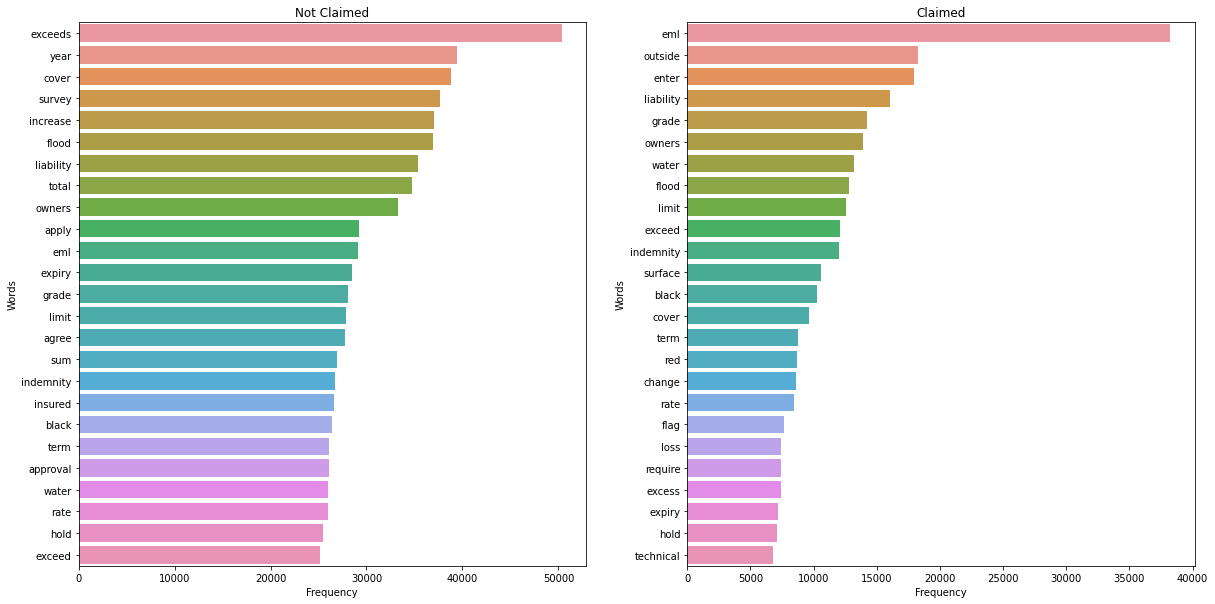

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20, 10))
sns.barplot(y="Words", x="Frequency", data=df_no_claim, ax=ax[0])
sns.barplot(y="Words", x="Frequency", data=df_claim, ax=ax[1])
ax[0].set_title('Not Claimed')
ax[1].set_title('Claimed')
fig.show()

In [ ]:
scores_CPO_no_claim = model[corpus_CPO_No_Claim]

In [ ]:
# Define a dictionary ``td`` where each document gather
td_CPO_no_claim = { 
    dct_CPO_No_Claim.get(_id): value for doc in scores_CPO_no_claim
    for _id, value in doc
    }

# Sort the items of ``td`` into a new variable ``sorted_td``
# the ``reverse`` starts from highest to lowest
sorted_td_CPO_no_claim = sorted(td_CPO_no_claim.items(), key=lambda kv: kv[1], reverse=True) 

In [ ]:
sorted_td_CPO_no_claim = pd.DataFrame(sorted_td_CPO_no_claim[0:25], columns=['Word','Weight'])

In [ ]:
scores_CPO_claim = model[corpus_CPO_Claim]

In [ ]:
# Define a dictionary ``td`` where each document gather
td_CPO_claim = { 
    dct_CPO_Claim.get(_id): value for doc in scores_CPO_claim
    for _id, value in doc
    }

# Sort the items of ``td`` into a new variable ``sorted_td``
# the ``reverse`` starts from highest to lowest
sorted_CPO_td_claim = sorted(td_CPO_claim.items(), key=lambda kv: kv[1], reverse=True) 

In [ ]:
sorted_CPO_td_claim = pd.DataFrame(sorted_CPO_td_claim[0:25], columns=['Word','Weight'])

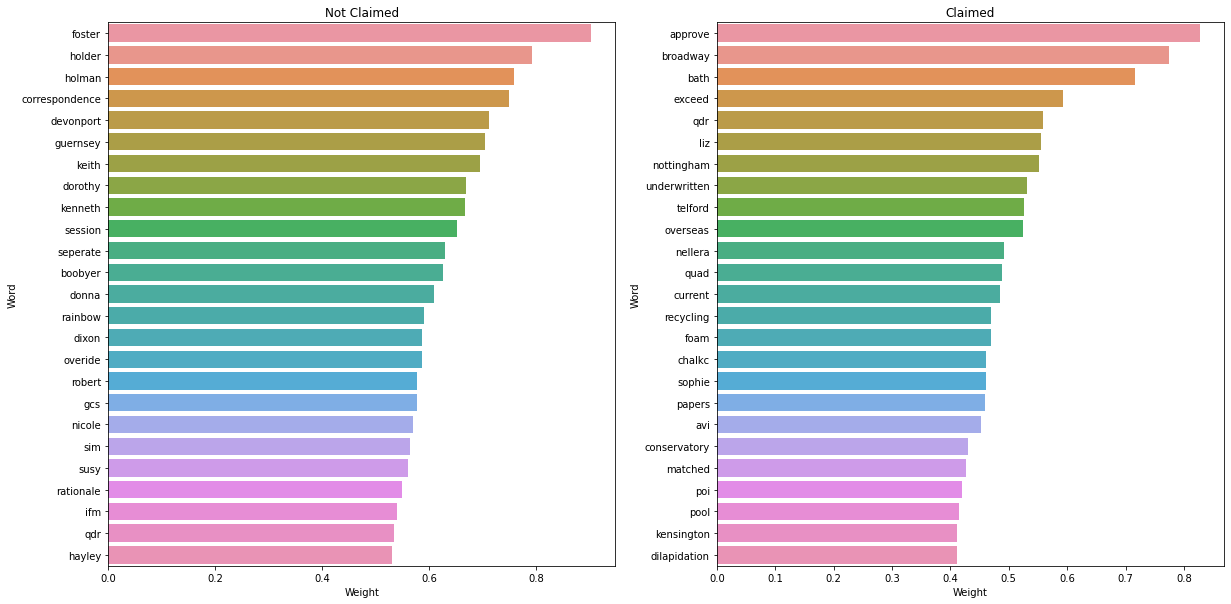

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20, 10))
sns.barplot(y="Word", x="Weight", data=sorted_td_CPO_no_claim, ax=ax[0])
sns.barplot(y="Word", x="Weight", data=sorted_CPO_td_claim, ax=ax[1])
ax[0].set_title('Not Claimed')
ax[1].set_title('Claimed')
fig.show()

# Word Context


In [ ]:
Claim_df = preprocessed[preprocessed["Claim"] == 'Yes']

In [ ]:
Not_claim_df = preprocessed[preprocessed["Claim"] != 'Yes']

In [ ]:
Claim_df['word'] = [any(b in s for b in ['granite']) for s in Claim_df.tokens]
Claim_df_word = Claim_df[Claim_df["word"] == True]
Claim_df_word

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Index,POLICYID,Text,Product_Code,Claim,Number_of_Claims,emails,emails_count,urls,url_flags,clean,adjs_verbs,nouns,entities,tokens,lemmas,length,word
122346,122347,401108946,Strategy - segment - property owner - resident...,CPO,Yes,1,[],0,[],0,Strategy segment property owner residential im...,"[improve, require, insure, sign, issue, expire...","[strategy, segment, property, owner, residenti...","[Authority_L3/ORG, Jackie_Crighton/PERSON, LTA...","[strategy, segment, property, owner, residenti...","[strategy, segment, property, owner, residenti...",581,True
123382,123383,401116073,U/W issue(s):\r\n\r\n1. Public Liability syste...,CCI,Yes,1,[],0,[],0,issue Public Liability system generated Endors...,"[issue, generate, unchecked, uncheck, honour, ...","[Public, Liability, system, Endorsement, Excee...","[Public_Liability/ORG, Endorsement/ORG, Exceed...","[issue, public, liability, system, generate, e...","[issue, public, liability, system, generate, e...",1655,True
124304,124305,401121516,U/W issue(s):\r\n\r\n1. Contract Works Free Fo...,CSI,Yes,2,[],0,[],0,issue Contract Works Free Format Wording Appli...,"[exceed, exceed, exceed, discuss, undertake, m...","[issue, contract, Works, Free, format, wording...",[contract_Works_Free_format_wording_Applied_ex...,"[issue, contract, works, free, format, wording...","[issue, contract, work, free, format, wording,...",622,True
124341,124342,401121709,Renewal terms Â£14800 + IPT - need to offer at...,CCI,Yes,2,[],0,[],0,Renewal terms 14800 IPT need to offer at least...,"[need, offer, assume, central, see, protect, a...","[renewal, term, IPT, saving, quote, intruder, ...","[Waterjet/ORG, UK/GPE, height/PERSON, Aviva_Ri...","[renewal, term, ipt, need, offer, save, quote,...","[renewal, term, ipt, need, offer, at, least, s...",336,True
125235,125236,401126750,Still awaiting info for renewal from Chris. Re...,CCI,Yes,3,[],0,[],0,Still awaiting info for renewal from Chris Rem...,"[await, invite, exist, unchanged, write, claim...","[info, renewal, Chris, Remined, number, time, ...","[Chris_Remined/PERSON, NB/ORG, Mawby/GPE, ARI_...","[await, info, renewal, chris, remined, number,...","[still, await, info, for, renewal, from, chris...",276,True
125463,125464,401127954,Strategy : Industrial Minerals - Maintain\r\n...,CCI,Yes,1,[],0,[],0,Strategy Industrial Minerals Maintain Claims N...,"[maintain, abdominal, heavy, pay, suspected, c...","[Strategy, Industrial, Minerals, claim, claim,...",[Strategy_Industrial_Minerals_maintain_claim/O...,"[strategy, industrial, minerals, maintain, cla...","[strategy, industrial, minerals, maintain, cla...",828,True
125768,125769,401129990,U/W issue(s):\r\n\r\n1. Contract Works Maximum...,CSI,Yes,1,[],0,[],0,issue Contract Works Maximum Contract Value Ex...,"[exceed, build, total, connect, main, specific...","[issue, Contract, Works, Maximum, Contract, va...",[Contract_Works_Maximum_Contract_value_exceed_...,"[issue, contract, works, maximum, contract, va...","[issue, contract, works, maximum, contract, va...",709,True
125848,125849,401130383,CIS have approached us for a favour.\r\n\r\nSe...,CCI,Yes,2,[],0,[],0,CIS have approached us for favour Serviced apa...,"[approach, favour, service, able, write, deal,...","[ci, apartment, centre, Aberdeen, business, in...","[Aberdeen/GPE, CIS/ORG, CIS/ORG, NIL/ORG, Expi...","[ci, approach, favour, serviced, apartment, ce...","[cis, have, approach, for, favour, serviced, a...",178,True
126024,126025,401131433,U/W issue(s):\r\n\r\n1. Surface Water Risk % o...,CCI,Yes,1,[],0,[],0,issue Surface Water Risk of Total Sum Insured ...,"[total, insure, exceed, exceed, wet, load, inc...","[issue, surface, Water, risk, Sum, Black, Grad...","[Rnl_18_Client/ORG, Business_Importers_Exporte...","[issue, surface, water, risk, total, sum, insu...","[issue, surface, water, risk, of, total, sum, ...",303,True
126108,126109,401131951,Rationale â€“ Melrosa Marble & Granite Ltd - R...,CCI,Yes,1,[],0,[],0,Rationale Melrosa Marble Granite Ltd Renewal 

In [ ]:
Claim_df_word.clean[146442]

'Request to include EL PL to the existing policy did quote for this at NB stage but now Justin Griffith has spoken to Ben Davis and asked us to do it for 000 Ben agreed we would deal with this as though on the Assure deal and match the premium Therefore we have applied modifiers to try and bring the technical down but essentially this is really cheap but told we had to do it at this premium Sam Tustin Got asked to quote for 300 000 worth of granite left in the open Checked survey that Martin Hill did although we were not insuring the grantie at this time The client has never insured client of their has insisted they insure it As 300 000 would warrant survey initally was going to to VRM but Justin at Brokers wanted to be there Spoke with Simon garfield and he was happy with where the granite was kept The FLT was kept inside out of hours and its keys locked away See file scanned on Client has set up new holding company Neo Granite Holdings Ltd and wants to add the the policy title Have i

In [ ]:
Not_claim_df['word'] = [any(b in s for b in ['retroactive']) for s in Not_claim_df.tokens]
Not_claim_df_word = Not_claim_df[Not_claim_df["word"] == True]
Not_claim_df_word

In [ ]:
Not_claim_df_word.clean[91857]

'Retroactive date taken as 12 18 as should be prior to inception'